# Python Basics


In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


DJ = pd.read_csv("csv/20M/BITCOIN_M20_202110010000_202205030000.csv",delim_whitespace=True)
timeFrame = int(input('TimeFrame :'))
CandlesInDay = 24 * (60//timeFrame)
DJ.insert(7, '<ISGREEN>',value=0)
DJ.insert(8, '<SIZE>',value=0)
DJ['<ISGREEN>'] =  DJ['<CLOSE>'] > DJ['<OPEN>']
DJ['<SIZE>'] =  DJ['<HIGH>'] - DJ['<LOW>']
DJ.drop(['<HIGH>','<LOW>','<TICKVOL>','<VOL>','<SPREAD>'],axis=1,inplace=True)



In [330]:
def candleToTime(j):
    minuteMult = CandlesInDay//24
    k=j//minuteMult
    sth=timeFrame*(j%minuteMult)
    return '{:02d}:{:02d}:00'.format(k,sth)

uniqueDays = DJ.drop_duplicates(subset='<DATE>')
uniqueDays = pd.DataFrame(uniqueDays)

uniqueDaysCount=uniqueDays.shape[0]


newDF = pd.DataFrame(columns=['<DATE>','<TIME>','<OPEN>','<CLOSE>','<ISGREEN>','<SIZE>'])




for i in range(uniqueDaysCount):

    if(i%120==0):
        print((int(i/uniqueDaysCount*10000))/100 , '%')
    for j in range(CandlesInDay):
        newDF.loc[(i*CandlesInDay)+j]=[uniqueDays.iloc[i][0],candleToTime(j),0,0,0,0]


0.0 %
55.81 %


In [331]:
newestDF = newDF.merge(DJ,on=['<DATE>','<TIME>'],how='left')

newestDF.drop(columns=['<OPEN>_x','<CLOSE>_x','<SIZE>_x','<ISGREEN>_x','<CLOSE>_y','<OPEN>_y'],inplace=True)
newestDF['<ISGREEN>_y'] = newestDF['<ISGREEN>_y'].fillna(0)
newestDF['<SIZE>_y'] = newestDF['<SIZE>_y'].fillna(0)



In [332]:
list = []
for i in range(len(newestDF)):
    date = newestDF.iloc[i][0]
    time = newestDF.iloc[i][1]
    isGreen = newestDF.iloc[i][2]
    size = newestDF.iloc[i][3]
    list.append([date, time, isGreen,size])


In [333]:
days = []
for i in range(uniqueDaysCount): 
    days.append(list[i*CandlesInDay: CandlesInDay*(i+1)])


In [338]:
avgMultiplier = float(input('Only calculate candles bigger than X times the average (def=1) :' )or '1')

def eachDayMatrix(day):
    avg=0
    for i in range(len(day)):
        avg+=abs(day[i][3])
    avg/=len(day)
    ansMatrix = np.zeros((CandlesInDay,CandlesInDay),dtype=int)
    countMatrix = np.zeros((CandlesInDay,CandlesInDay),dtype=int)
    for i in range(len(day)) : 
        for j in range (i,len(day)):
            if abs(day[i][3])> avg*avgMultiplier and abs(day[j][3])> 0:
                countMatrix[i][j] += 1
                ansMatrix[i][j]=1 if not(day[i][2] ^ day[j][2]) else -1
                continue
            ansMatrix[i][j]=0
            

    return [ansMatrix,countMatrix]

ansVector = []
countVector = []
for i in range(len(days)):
    countVector.append(eachDayMatrix(days[i])[1])
    ansVector.append(eachDayMatrix(days[i])[0])

final = np.sum(ansVector, axis=0)
countFinal = np.sum(countVector, axis=0)
# final-=len(days)//2
# plt.imshow(final)



<AxesSubplot:>

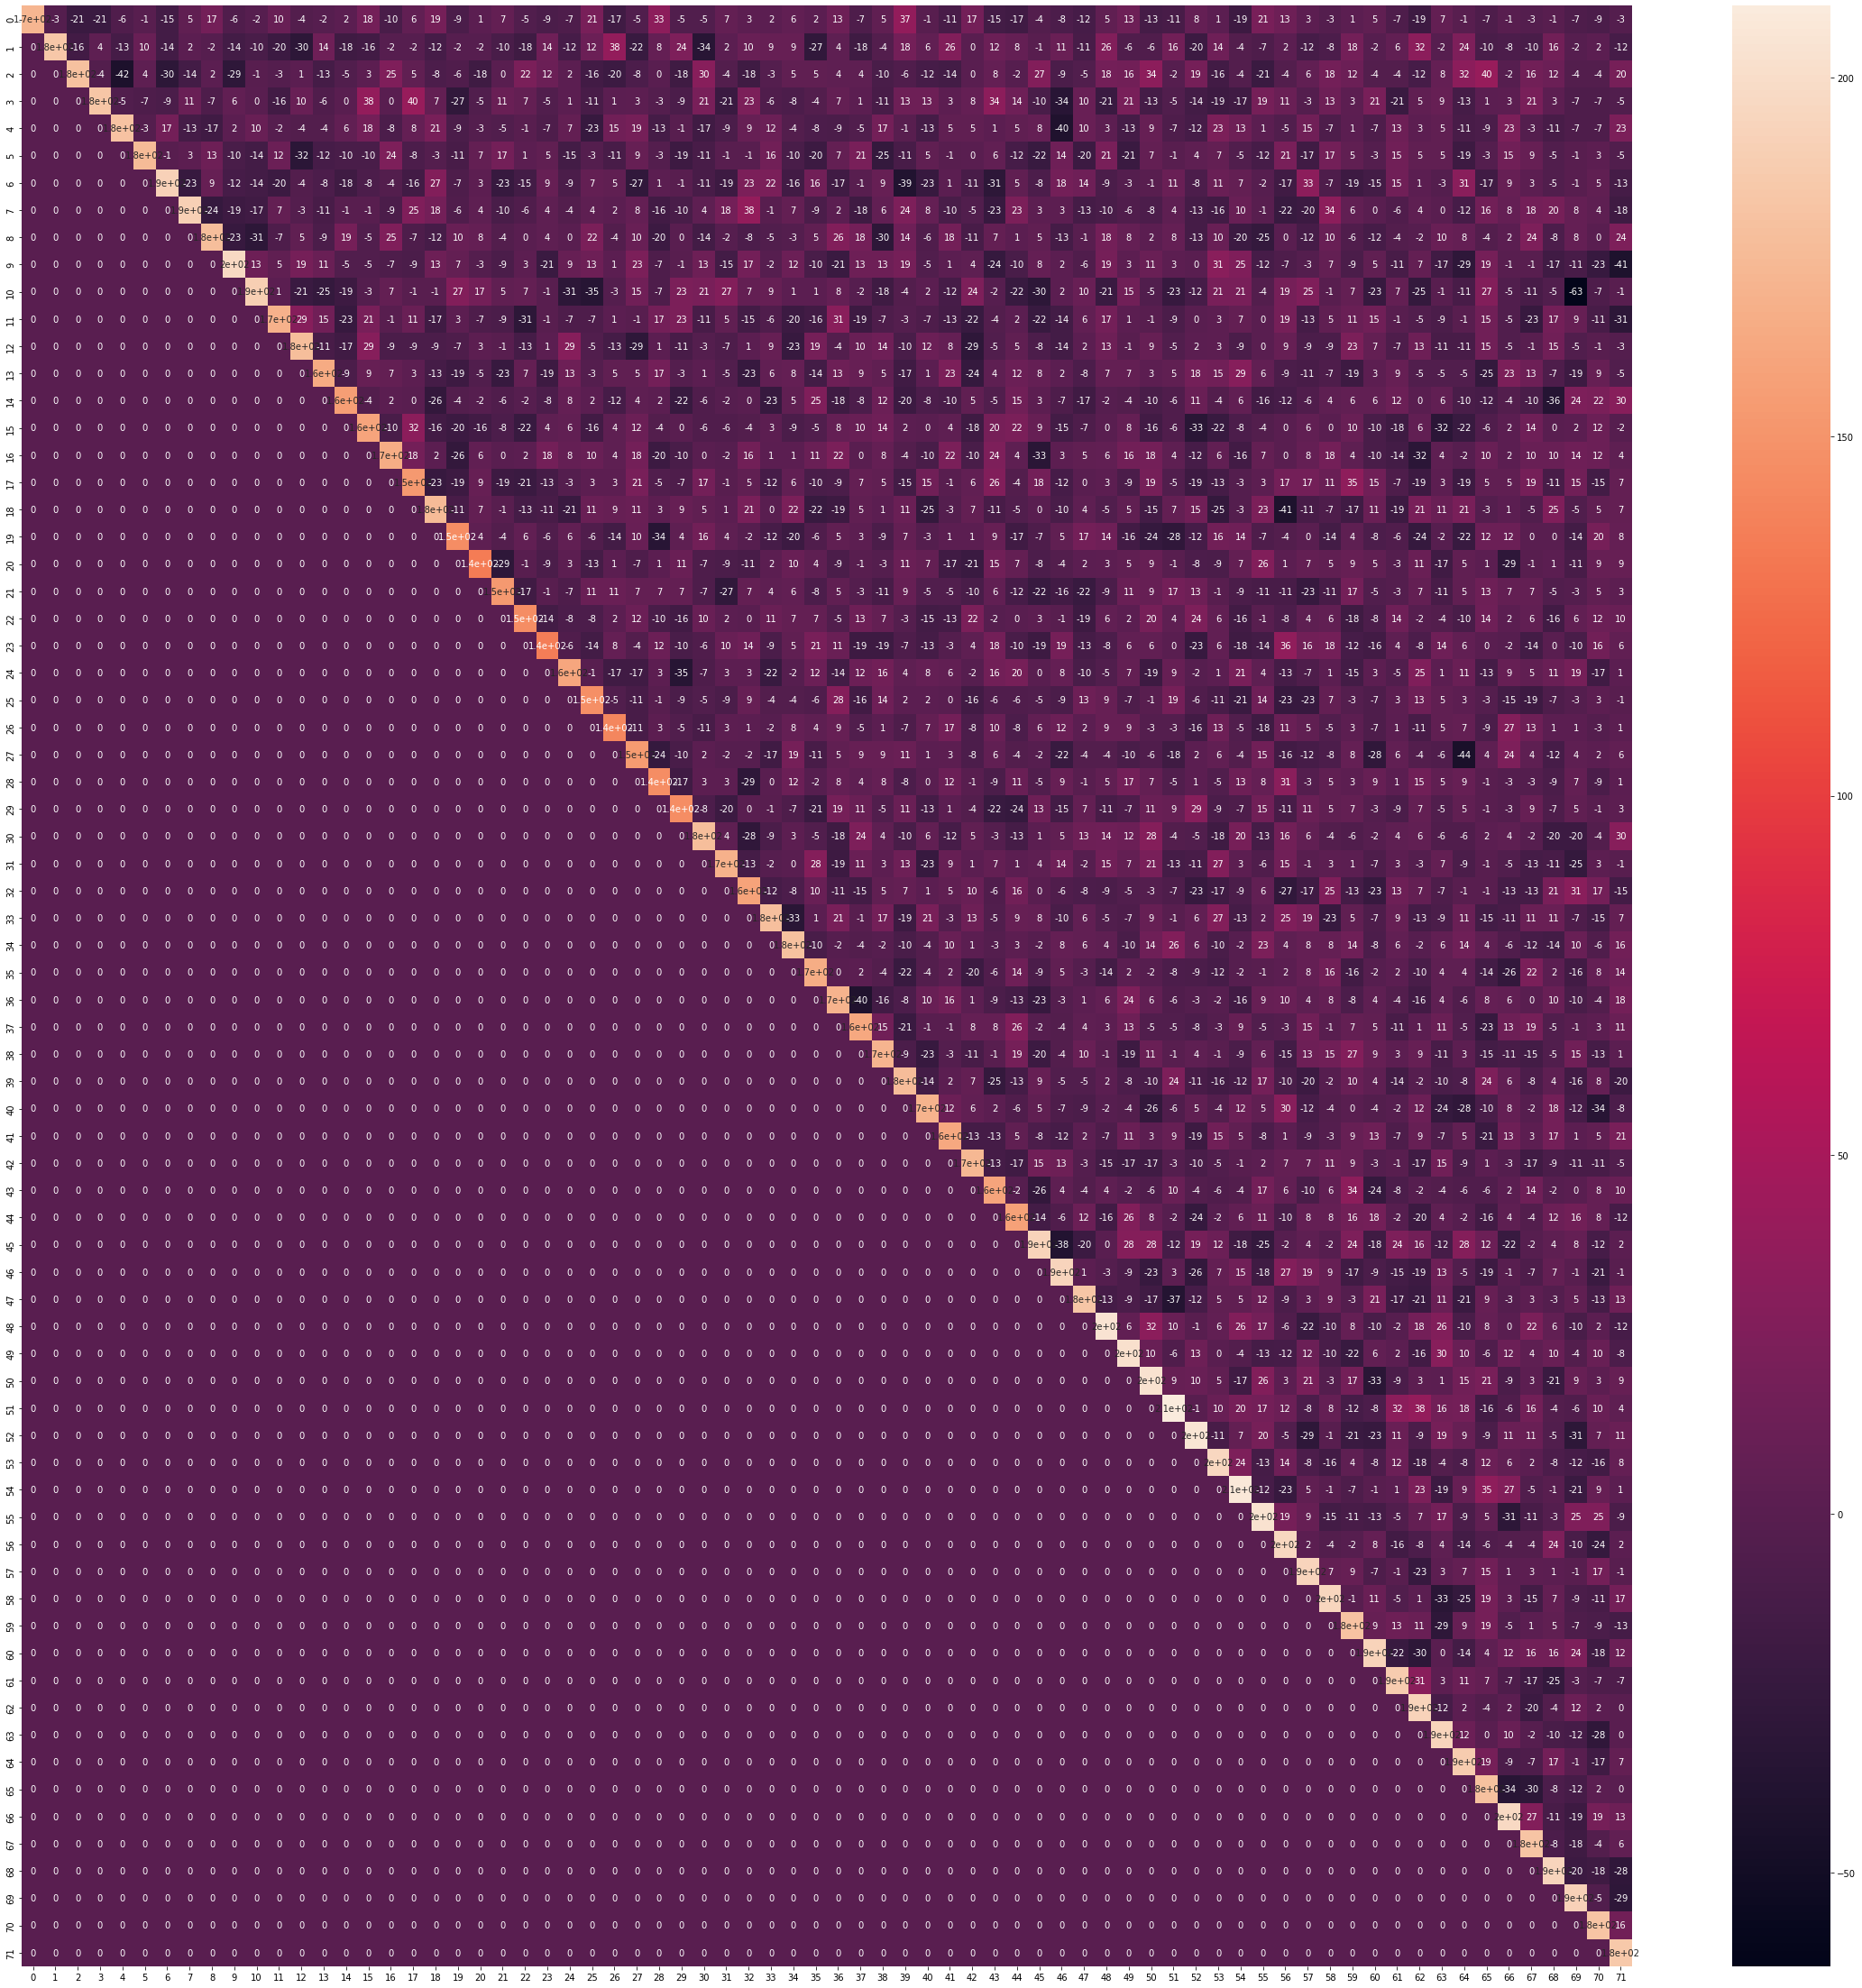

In [335]:
plt.figure(figsize=(40,40))
sns.heatmap(final,annot=True,)


<AxesSubplot:>

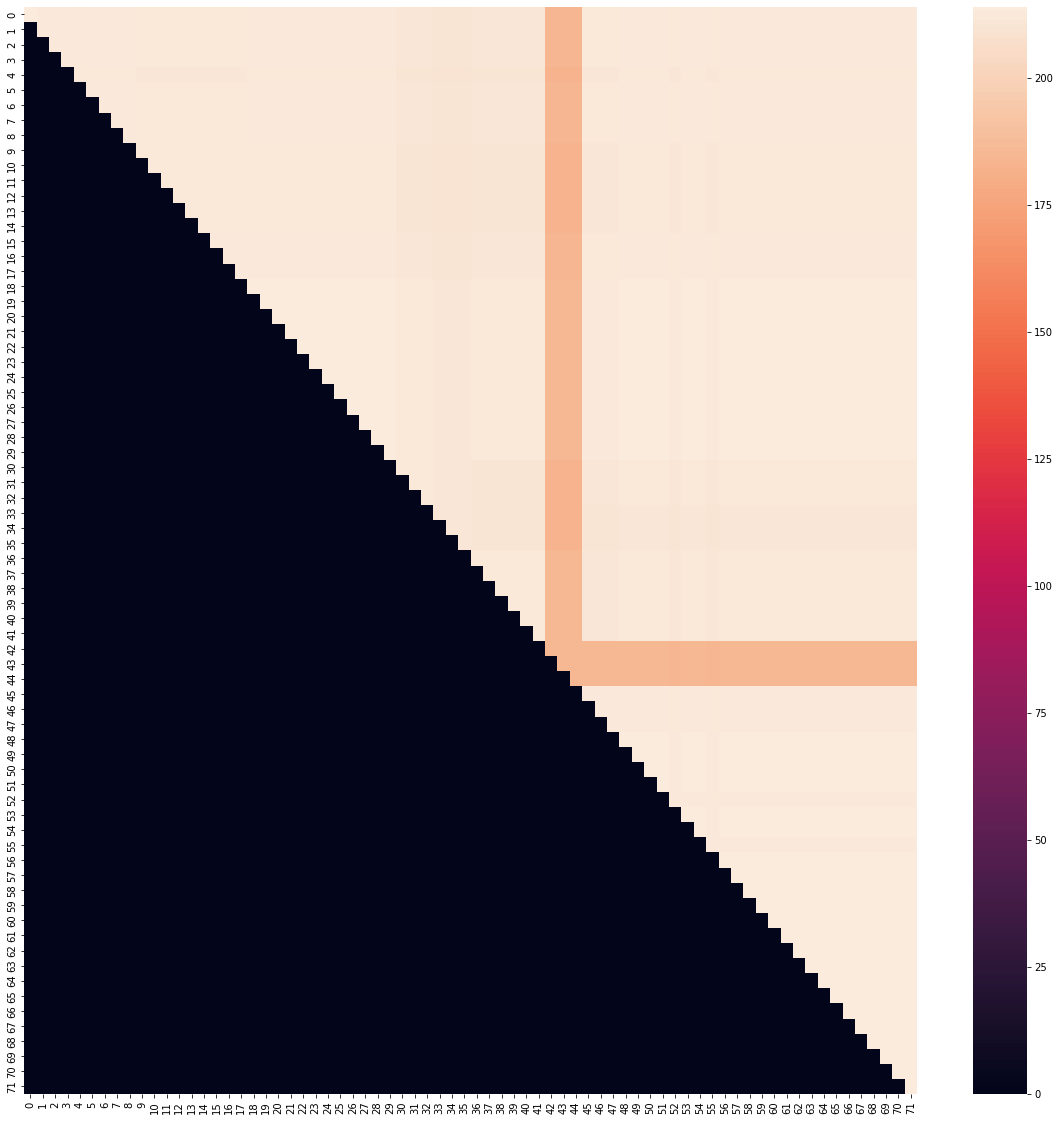

In [339]:
plt.figure(figsize=(20,20))
sns.heatmap(countFinal,annot=False,)


In [340]:
# float(input('Bias:')) 
bias = .5

consecutiveAndClose = False
consecutiveOnly = True
percentTimesCountedAtLeastMoreThan = 50


for i in range(len(final)):
    for j in range (i,len(final)):
        percentageHigherThanAvg = int(countFinal[i][j]/uniqueDaysCount *10000) /100
        if( percentageHigherThanAvg < percentTimesCountedAtLeastMoreThan ):
            continue
        prob = abs(final[i][j]) / countFinal[i][j] + 0.5
        if (bias<prob<1)and (not i==j):
            prob100 = int(prob*10000)/100
            if(j-i==1):
                print(f"{i}-{j}",f"{candleToTime(i)}-{candleToTime(j)}",f"{prob100}% ++",percentageHigherThanAvg,'Consecutive') if final[i][j]>=0 else print(f"{i}-{j}",f"{candleToTime(i)}-{candleToTime(j)}",f"{prob100}% --",percentageHigherThanAvg,'Consecutive')
                continue
            if(j-i <= 120/timeFrame) and (not consecutiveOnly):
                print(f"{i}-{j}",f"{candleToTime(i)}-{candleToTime(j)}",f"{prob100}% ++",percentageHigherThanAvg,'Close') if final[i][j]>=0 else print(f"{i}-{j}",f"{candleToTime(i)}-{candleToTime(j)}",f"{prob100}% --",percentageHigherThanAvg,'Close')
                continue
            if not(consecutiveAndClose or consecutiveOnly): 
                print(f"{i}-{j}",f"{candleToTime(i)}-{candleToTime(j)}",f"{prob100}% ++",percentageHigherThanAvg) if final[i][j]>=0 else print(f"{i}-{j}",f"{candleToTime(i)}-{candleToTime(j)}",f"{prob100}% --",percentageHigherThanAvg)





0-1 00:00:00-00:20:00 56.1% -- 99.06 Consecutive
1-2 00:20:00-00:40:00 59.85% -- 99.06 Consecutive
2-3 00:40:00-01:00:00 50.46% -- 99.06 Consecutive
3-4 01:00:00-01:20:00 51.88% -- 98.6 Consecutive
4-5 01:20:00-01:40:00 51.88% -- 98.6 Consecutive
5-6 01:40:00-02:00:00 50.46% ++ 99.06 Consecutive
6-7 02:00:00-02:20:00 57.04% -- 99.06 Consecutive
7-8 02:20:00-02:40:00 61.73% -- 99.06 Consecutive
8-9 02:40:00-03:00:00 55.66% -- 98.6 Consecutive
9-10 03:00:00-03:20:00 56.6% ++ 98.6 Consecutive
10-11 03:20:00-03:40:00 51.88% -- 98.6 Consecutive
11-12 03:40:00-04:00:00 62.26% ++ 98.6 Consecutive
12-13 04:00:00-04:20:00 52.83% -- 98.6 Consecutive
13-14 04:20:00-04:40:00 51.88% -- 98.6 Consecutive
14-15 04:40:00-05:00:00 50.94% -- 98.6 Consecutive
15-16 05:00:00-05:20:00 57.98% -- 99.06 Consecutive
16-17 05:20:00-05:40:00 57.04% ++ 99.06 Consecutive
17-18 05:40:00-06:00:00 68.3% -- 99.06 Consecutive
18-19 06:00:00-06:20:00 58.41% -- 99.53 Consecutive
19-20 06:20:00-06:40:00 52.8% -- 99.53 Cons